# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

/Users/sebastianmuhle/opt/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

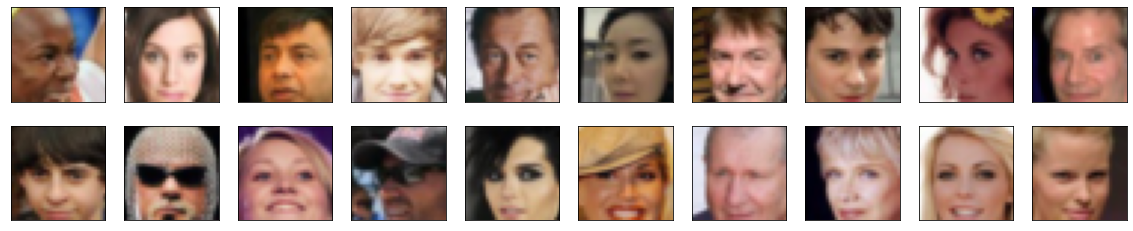

In [14]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [15]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9451)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [21]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [22]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [23]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/Users/sebastianmuhle/opt/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [24]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight.data, 0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [26]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [28]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    labels = torch.ones(D_out.size(0))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    labels = torch.zeros(D_out.size(0))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [29]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [30]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [31]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3525 | g_loss: 1.1625
Epoch [    1/   50] | d_loss: 0.2156 | g_loss: 3.5444
Epoch [    1/   50] | d_loss: 0.2537 | g_loss: 3.5004
Epoch [    1/   50] | d_loss: 0.1415 | g_loss: 4.4599
Epoch [    1/   50] | d_loss: 0.1698 | g_loss: 2.9158
Epoch [    1/   50] | d_loss: 0.4407 | g_loss: 2.1498
Epoch [    1/   50] | d_loss: 0.3692 | g_loss: 2.2274
Epoch [    1/   50] | d_loss: 0.4480 | g_loss: 1.5941
Epoch [    1/   50] | d_loss: 0.5501 | g_loss: 2.5266
Epoch [    1/   50] | d_loss: 0.6892 | g_loss: 2.9098
Epoch [    1/   50] | d_loss: 0.5948 | g_loss: 1.9085
Epoch [    1/   50] | d_loss: 0.6791 | g_loss: 2.2688
Epoch [    1/   50] | d_loss: 0.9436 | g_loss: 1.1621
Epoch [    1/   50] | d_loss: 0.8821 | g_loss: 1.3480
Epoch [    1/   50] | d_loss: 0.7950 | g_loss: 1.1724
Epoch [    1/   50] | d_loss: 0.7950 | g_loss: 2.2853
Epoch [    1/   50] | d_loss: 0.6660 | g_loss: 2.4966
Epoch [    1/   50] | d_loss: 1.1313 | g_loss: 3.5974
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.8427 | g_loss: 1.6971
Epoch [    3/   50] | d_loss: 1.4002 | g_loss: 0.6463
Epoch [    3/   50] | d_loss: 0.9507 | g_loss: 1.6766
Epoch [    3/   50] | d_loss: 0.7446 | g_loss: 1.7842
Epoch [    3/   50] | d_loss: 0.9640 | g_loss: 1.8220
Epoch [    3/   50] | d_loss: 0.8938 | g_loss: 1.2277
Epoch [    3/   50] | d_loss: 1.1032 | g_loss: 1.2948
Epoch [    3/   50] | d_loss: 0.8922 | g_loss: 1.8170
Epoch [    3/   50] | d_loss: 0.9746 | g_loss: 1.8435
Epoch [    3/   50] | d_loss: 1.0671 | g_loss: 0.7246
Epoch [    3/   50] | d_loss: 1.0578 | g_loss: 1.0911
Epoch [    3/   50] | d_loss: 0.7924 | g_loss: 1.5421
Epoch [    3/   50] | d_loss: 1.0735 | g_loss: 1.7802
Epoch [    3/   50] | d_loss: 0.7976 | g_loss: 1.0761
Epoch [    3/   50] | d_loss: 0.6854 | g_loss: 1.9612
Epoch [    3/   50] | d_loss: 0.9218 | g_loss: 1.5110
Epoch [    3/   50] | d_loss: 0.8248 | g_loss: 1.8978
Epoch [    3/   50] | d_loss: 1.2273 | g_loss: 1.5825
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.6723 | g_loss: 1.5998
Epoch [    6/   50] | d_loss: 0.5897 | g_loss: 1.8327
Epoch [    6/   50] | d_loss: 0.8383 | g_loss: 1.3438
Epoch [    6/   50] | d_loss: 0.3721 | g_loss: 2.8387
Epoch [    6/   50] | d_loss: 0.6771 | g_loss: 0.9479
Epoch [    6/   50] | d_loss: 0.6656 | g_loss: 1.5472
Epoch [    6/   50] | d_loss: 0.5271 | g_loss: 2.4973
Epoch [    6/   50] | d_loss: 0.7360 | g_loss: 1.1844
Epoch [    6/   50] | d_loss: 0.4415 | g_loss: 2.3140
Epoch [    6/   50] | d_loss: 0.5573 | g_loss: 2.9969
Epoch [    6/   50] | d_loss: 0.6783 | g_loss: 1.7585
Epoch [    6/   50] | d_loss: 1.4619 | g_loss: 3.7057
Epoch [    6/   50] | d_loss: 0.8303 | g_loss: 1.7451
Epoch [    6/   50] | d_loss: 0.7525 | g_loss: 2.5375
Epoch [    6/   50] | d_loss: 0.5946 | g_loss: 1.2708
Epoch [    6/   50] | d_loss: 0.5632 | g_loss: 2.1364
Epoch [    6/   50] | d_loss: 0.5215 | g_loss: 1.3984
Epoch [    6/   50] | d_loss: 0.8572 | g_loss: 1.3208
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.4711 | g_loss: 2.7725
Epoch [    9/   50] | d_loss: 0.3787 | g_loss: 2.5493
Epoch [    9/   50] | d_loss: 2.4797 | g_loss: 1.9236
Epoch [    9/   50] | d_loss: 0.1590 | g_loss: 4.6632
Epoch [    9/   50] | d_loss: 0.2751 | g_loss: 2.3002
Epoch [    9/   50] | d_loss: 0.4796 | g_loss: 1.9719
Epoch [    9/   50] | d_loss: 0.3724 | g_loss: 2.7553
Epoch [    9/   50] | d_loss: 0.2332 | g_loss: 2.4913
Epoch [    9/   50] | d_loss: 0.4567 | g_loss: 2.4915
Epoch [    9/   50] | d_loss: 1.0582 | g_loss: 1.1266
Epoch [    9/   50] | d_loss: 0.4723 | g_loss: 1.8236
Epoch [    9/   50] | d_loss: 1.0505 | g_loss: 2.7811
Epoch [    9/   50] | d_loss: 0.2978 | g_loss: 2.5587
Epoch [    9/   50] | d_loss: 0.6269 | g_loss: 1.4389
Epoch [    9/   50] | d_loss: 0.4430 | g_loss: 2.2931
Epoch [    9/   50] | d_loss: 0.4896 | g_loss: 2.6785
Epoch [    9/   50] | d_loss: 0.7562 | g_loss: 2.7230
Epoch [    9/   50] | d_loss: 0.6568 | g_loss: 2.6879
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.2131 | g_loss: 4.4457
Epoch [   11/   50] | d_loss: 0.3905 | g_loss: 2.5132
Epoch [   11/   50] | d_loss: 0.1490 | g_loss: 2.6247
Epoch [   11/   50] | d_loss: 0.1802 | g_loss: 2.8732
Epoch [   11/   50] | d_loss: 0.2617 | g_loss: 2.4741
Epoch [   11/   50] | d_loss: 0.3604 | g_loss: 3.6792
Epoch [   11/   50] | d_loss: 0.4514 | g_loss: 2.8878
Epoch [   11/   50] | d_loss: 0.2184 | g_loss: 5.0754
Epoch [   11/   50] | d_loss: 0.2333 | g_loss: 2.3591
Epoch [   11/   50] | d_loss: 0.2057 | g_loss: 2.5706
Epoch [   11/   50] | d_loss: 0.4559 | g_loss: 2.6545
Epoch [   11/   50] | d_loss: 0.3794 | g_loss: 2.7181
Epoch [   11/   50] | d_loss: 0.6870 | g_loss: 4.6471
Epoch [   11/   50] | d_loss: 0.4309 | g_loss: 3.9650
Epoch [   11/   50] | d_loss: 0.1553 | g_loss: 2.6167
Epoch [   11/   50] | d_loss: 0.1390 | g_loss: 2.4921
Epoch [   11/   50] | d_loss: 0.1863 | g_loss: 3.7827
Epoch [   11/   50] | d_loss: 0.2270 | g_loss: 2.9665
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.2214 | g_loss: 3.0261
Epoch [   14/   50] | d_loss: 0.1315 | g_loss: 1.9992
Epoch [   14/   50] | d_loss: 0.7622 | g_loss: 2.5208
Epoch [   14/   50] | d_loss: 0.0718 | g_loss: 4.8026
Epoch [   14/   50] | d_loss: 0.2484 | g_loss: 2.8462
Epoch [   14/   50] | d_loss: 0.6731 | g_loss: 2.2315
Epoch [   14/   50] | d_loss: 0.2802 | g_loss: 3.2968
Epoch [   14/   50] | d_loss: 0.3212 | g_loss: 3.3588
Epoch [   14/   50] | d_loss: 0.5400 | g_loss: 1.8235
Epoch [   14/   50] | d_loss: 0.1297 | g_loss: 3.4927
Epoch [   14/   50] | d_loss: 0.5710 | g_loss: 1.5255
Epoch [   14/   50] | d_loss: 0.1614 | g_loss: 3.3370
Epoch [   14/   50] | d_loss: 0.2963 | g_loss: 4.5530
Epoch [   14/   50] | d_loss: 0.5614 | g_loss: 1.5059
Epoch [   14/   50] | d_loss: 0.7626 | g_loss: 1.3052
Epoch [   14/   50] | d_loss: 0.3070 | g_loss: 4.1936
Epoch [   14/   50] | d_loss: 0.1758 | g_loss: 3.3308
Epoch [   14/   50] | d_loss: 0.3024 | g_loss: 1.8755
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.5916 | g_loss: 2.3830
Epoch [   17/   50] | d_loss: 0.2601 | g_loss: 3.9859
Epoch [   17/   50] | d_loss: 0.1838 | g_loss: 3.9983
Epoch [   17/   50] | d_loss: 0.0369 | g_loss: 3.8640
Epoch [   17/   50] | d_loss: 0.2050 | g_loss: 3.2207
Epoch [   17/   50] | d_loss: 0.3323 | g_loss: 3.0427
Epoch [   17/   50] | d_loss: 0.1701 | g_loss: 4.7152
Epoch [   17/   50] | d_loss: 0.2395 | g_loss: 4.8855
Epoch [   17/   50] | d_loss: 0.1861 | g_loss: 4.8806
Epoch [   17/   50] | d_loss: 0.3832 | g_loss: 3.8149
Epoch [   17/   50] | d_loss: 0.6572 | g_loss: 2.3729
Epoch [   17/   50] | d_loss: 0.2981 | g_loss: 3.4887
Epoch [   17/   50] | d_loss: 0.1549 | g_loss: 3.9126
Epoch [   17/   50] | d_loss: 0.1155 | g_loss: 3.6963
Epoch [   17/   50] | d_loss: 0.0923 | g_loss: 4.9429
Epoch [   17/   50] | d_loss: 0.1167 | g_loss: 2.6853
Epoch [   17/   50] | d_loss: 0.1156 | g_loss: 3.4697
Epoch [   17/   50] | d_loss: 0.2031 | g_loss: 3.5095
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0644 | g_loss: 3.6252
Epoch [   19/   50] | d_loss: 0.7933 | g_loss: 2.5429
Epoch [   19/   50] | d_loss: 0.1689 | g_loss: 4.6051
Epoch [   19/   50] | d_loss: 0.1806 | g_loss: 2.6499
Epoch [   19/   50] | d_loss: 0.0903 | g_loss: 4.2481
Epoch [   19/   50] | d_loss: 0.1206 | g_loss: 3.9956
Epoch [   19/   50] | d_loss: 0.1640 | g_loss: 3.9275
Epoch [   19/   50] | d_loss: 0.0364 | g_loss: 4.3624
Epoch [   19/   50] | d_loss: 0.0998 | g_loss: 3.4789
Epoch [   19/   50] | d_loss: 0.0674 | g_loss: 3.5723
Epoch [   19/   50] | d_loss: 0.1753 | g_loss: 5.2388
Epoch [   19/   50] | d_loss: 0.0815 | g_loss: 3.3661
Epoch [   19/   50] | d_loss: 0.1839 | g_loss: 2.8002
Epoch [   19/   50] | d_loss: 0.1376 | g_loss: 4.7499
Epoch [   19/   50] | d_loss: 0.1586 | g_loss: 4.7657
Epoch [   19/   50] | d_loss: 0.1438 | g_loss: 3.7814
Epoch [   19/   50] | d_loss: 0.0616 | g_loss: 5.4011
Epoch [   19/   50] | d_loss: 0.2982 | g_loss: 3.3735
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.0776 | g_loss: 4.2547
Epoch [   22/   50] | d_loss: 0.0340 | g_loss: 3.9824
Epoch [   22/   50] | d_loss: 0.5828 | g_loss: 2.6952
Epoch [   22/   50] | d_loss: 0.0488 | g_loss: 4.9620
Epoch [   22/   50] | d_loss: 0.1995 | g_loss: 3.2810
Epoch [   22/   50] | d_loss: 0.0492 | g_loss: 4.3537
Epoch [   22/   50] | d_loss: 0.1883 | g_loss: 5.0683
Epoch [   22/   50] | d_loss: 0.2236 | g_loss: 4.7339
Epoch [   22/   50] | d_loss: 0.1369 | g_loss: 4.3837
Epoch [   22/   50] | d_loss: 0.0266 | g_loss: 5.5302
Epoch [   22/   50] | d_loss: 0.0922 | g_loss: 3.4458
Epoch [   22/   50] | d_loss: 0.0711 | g_loss: 4.8656
Epoch [   22/   50] | d_loss: 0.1188 | g_loss: 5.0891
Epoch [   22/   50] | d_loss: 0.1716 | g_loss: 2.3954
Epoch [   22/   50] | d_loss: 0.0733 | g_loss: 4.2670
Epoch [   22/   50] | d_loss: 1.1441 | g_loss: 8.5219
Epoch [   22/   50] | d_loss: 0.0801 | g_loss: 3.6207
Epoch [   22/   50] | d_loss: 0.3228 | g_loss: 2.8486
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.0883 | g_loss: 4.6859
Epoch [   25/   50] | d_loss: 0.2216 | g_loss: 4.3717
Epoch [   25/   50] | d_loss: 0.2118 | g_loss: 3.7532
Epoch [   25/   50] | d_loss: 0.0267 | g_loss: 5.8981
Epoch [   25/   50] | d_loss: 0.1107 | g_loss: 2.9867
Epoch [   25/   50] | d_loss: 0.0775 | g_loss: 3.0705
Epoch [   25/   50] | d_loss: 0.0568 | g_loss: 4.1693
Epoch [   25/   50] | d_loss: 0.0625 | g_loss: 2.2998
Epoch [   25/   50] | d_loss: 0.0448 | g_loss: 4.6632
Epoch [   25/   50] | d_loss: 0.0933 | g_loss: 4.2783
Epoch [   25/   50] | d_loss: 0.0810 | g_loss: 4.5561
Epoch [   25/   50] | d_loss: 0.1904 | g_loss: 3.9298
Epoch [   25/   50] | d_loss: 0.1022 | g_loss: 5.6338
Epoch [   25/   50] | d_loss: 0.2206 | g_loss: 4.2255
Epoch [   25/   50] | d_loss: 0.0950 | g_loss: 4.7323
Epoch [   25/   50] | d_loss: 0.0351 | g_loss: 5.7431
Epoch [   25/   50] | d_loss: 0.0762 | g_loss: 5.0828
Epoch [   25/   50] | d_loss: 0.1377 | g_loss: 3.2661
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.1545 | g_loss: 3.1697
Epoch [   27/   50] | d_loss: 0.1181 | g_loss: 6.2581
Epoch [   27/   50] | d_loss: 0.3539 | g_loss: 2.3148
Epoch [   27/   50] | d_loss: 0.4228 | g_loss: 2.3738
Epoch [   27/   50] | d_loss: 0.1950 | g_loss: 4.6387
Epoch [   27/   50] | d_loss: 0.0956 | g_loss: 4.6134
Epoch [   27/   50] | d_loss: 0.0651 | g_loss: 4.2185
Epoch [   27/   50] | d_loss: 0.1520 | g_loss: 3.9469
Epoch [   27/   50] | d_loss: 0.0701 | g_loss: 5.2805
Epoch [   27/   50] | d_loss: 0.1402 | g_loss: 4.6529
Epoch [   27/   50] | d_loss: 0.0551 | g_loss: 5.9679
Epoch [   27/   50] | d_loss: 0.2465 | g_loss: 2.2374
Epoch [   27/   50] | d_loss: 0.0551 | g_loss: 4.3379
Epoch [   27/   50] | d_loss: 0.0774 | g_loss: 3.8294
Epoch [   27/   50] | d_loss: 0.0365 | g_loss: 3.7570
Epoch [   27/   50] | d_loss: 0.0379 | g_loss: 4.3384
Epoch [   27/   50] | d_loss: 0.0452 | g_loss: 6.4542
Epoch [   27/   50] | d_loss: 0.1037 | g_loss: 4.8707
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.0323 | g_loss: 4.6579
Epoch [   30/   50] | d_loss: 0.0329 | g_loss: 5.2871
Epoch [   30/   50] | d_loss: 0.2581 | g_loss: 3.2599
Epoch [   30/   50] | d_loss: 0.0293 | g_loss: 5.1045
Epoch [   30/   50] | d_loss: 1.2686 | g_loss: 1.3229
Epoch [   30/   50] | d_loss: 0.3944 | g_loss: 3.9827
Epoch [   30/   50] | d_loss: 0.5316 | g_loss: 4.8300
Epoch [   30/   50] | d_loss: 0.1626 | g_loss: 4.3638
Epoch [   30/   50] | d_loss: 0.1367 | g_loss: 4.2044
Epoch [   30/   50] | d_loss: 0.0593 | g_loss: 5.2068
Epoch [   30/   50] | d_loss: 0.1742 | g_loss: 4.1765
Epoch [   30/   50] | d_loss: 0.1045 | g_loss: 5.9196
Epoch [   30/   50] | d_loss: 0.0824 | g_loss: 5.4393
Epoch [   30/   50] | d_loss: 0.0665 | g_loss: 4.2069
Epoch [   30/   50] | d_loss: 0.1766 | g_loss: 3.7594
Epoch [   30/   50] | d_loss: 0.0160 | g_loss: 4.4894
Epoch [   30/   50] | d_loss: 0.0586 | g_loss: 5.0280
Epoch [   30/   50] | d_loss: 0.1216 | g_loss: 5.6416
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0782 | g_loss: 5.9930
Epoch [   33/   50] | d_loss: 0.0290 | g_loss: 6.2210
Epoch [   33/   50] | d_loss: 0.0592 | g_loss: 5.5152
Epoch [   33/   50] | d_loss: 0.0269 | g_loss: 5.5933
Epoch [   33/   50] | d_loss: 0.0680 | g_loss: 4.2734
Epoch [   33/   50] | d_loss: 0.1690 | g_loss: 2.9153
Epoch [   33/   50] | d_loss: 0.0228 | g_loss: 5.5324
Epoch [   33/   50] | d_loss: 0.2069 | g_loss: 4.1401
Epoch [   33/   50] | d_loss: 0.0448 | g_loss: 3.9333
Epoch [   33/   50] | d_loss: 0.0376 | g_loss: 5.0038
Epoch [   33/   50] | d_loss: 0.2671 | g_loss: 3.2956
Epoch [   33/   50] | d_loss: 0.0110 | g_loss: 4.9334
Epoch [   33/   50] | d_loss: 0.0373 | g_loss: 6.0179
Epoch [   33/   50] | d_loss: 1.6391 | g_loss: 1.1823
Epoch [   33/   50] | d_loss: 0.1190 | g_loss: 4.8082
Epoch [   33/   50] | d_loss: 0.6404 | g_loss: 3.3404
Epoch [   33/   50] | d_loss: 0.1669 | g_loss: 3.8390
Epoch [   33/   50] | d_loss: 0.0396 | g_loss: 4.4407
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0858 | g_loss: 6.2049
Epoch [   35/   50] | d_loss: 0.0434 | g_loss: 6.2644
Epoch [   35/   50] | d_loss: 0.0472 | g_loss: 5.9675
Epoch [   35/   50] | d_loss: 0.0813 | g_loss: 5.9757
Epoch [   35/   50] | d_loss: 0.0227 | g_loss: 5.2846
Epoch [   35/   50] | d_loss: 0.0495 | g_loss: 4.0262
Epoch [   35/   50] | d_loss: 0.0145 | g_loss: 4.2959
Epoch [   35/   50] | d_loss: 0.0979 | g_loss: 4.9579
Epoch [   35/   50] | d_loss: 0.0301 | g_loss: 5.1983
Epoch [   35/   50] | d_loss: 0.0580 | g_loss: 4.5746
Epoch [   35/   50] | d_loss: 0.0113 | g_loss: 4.7702
Epoch [   35/   50] | d_loss: 0.0647 | g_loss: 4.8212
Epoch [   35/   50] | d_loss: 0.0415 | g_loss: 4.4433
Epoch [   35/   50] | d_loss: 0.0458 | g_loss: 4.9642
Epoch [   35/   50] | d_loss: 0.9483 | g_loss: 2.1883
Epoch [   35/   50] | d_loss: 3.9289 | g_loss: 6.1598
Epoch [   35/   50] | d_loss: 0.4185 | g_loss: 4.5519
Epoch [   35/   50] | d_loss: 0.1069 | g_loss: 4.4250
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0158 | g_loss: 4.9982
Epoch [   38/   50] | d_loss: 0.0106 | g_loss: 5.4057
Epoch [   38/   50] | d_loss: 0.2433 | g_loss: 3.0705
Epoch [   38/   50] | d_loss: 0.0522 | g_loss: 6.3130
Epoch [   38/   50] | d_loss: 0.0695 | g_loss: 5.9036
Epoch [   38/   50] | d_loss: 0.2225 | g_loss: 4.4651
Epoch [   38/   50] | d_loss: 0.1063 | g_loss: 4.9710
Epoch [   38/   50] | d_loss: 0.3648 | g_loss: 2.9522
Epoch [   38/   50] | d_loss: 0.0967 | g_loss: 6.3695
Epoch [   38/   50] | d_loss: 0.0146 | g_loss: 5.6868
Epoch [   38/   50] | d_loss: 0.0687 | g_loss: 4.5975
Epoch [   38/   50] | d_loss: 0.0545 | g_loss: 5.2771
Epoch [   38/   50] | d_loss: 0.1108 | g_loss: 4.7784
Epoch [   38/   50] | d_loss: 0.0351 | g_loss: 5.3248
Epoch [   38/   50] | d_loss: 0.2127 | g_loss: 5.6728
Epoch [   38/   50] | d_loss: 0.0615 | g_loss: 5.1519
Epoch [   38/   50] | d_loss: 0.0199 | g_loss: 5.6917
Epoch [   38/   50] | d_loss: 0.0426 | g_loss: 6.5545
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.0874 | g_loss: 5.9402
Epoch [   41/   50] | d_loss: 0.0570 | g_loss: 4.4757
Epoch [   41/   50] | d_loss: 0.0423 | g_loss: 6.7978
Epoch [   41/   50] | d_loss: 0.0141 | g_loss: 4.5206
Epoch [   41/   50] | d_loss: 0.1268 | g_loss: 3.7599
Epoch [   41/   50] | d_loss: 0.0631 | g_loss: 5.3594
Epoch [   41/   50] | d_loss: 0.0553 | g_loss: 6.3488
Epoch [   41/   50] | d_loss: 0.0604 | g_loss: 3.7978
Epoch [   41/   50] | d_loss: 0.0480 | g_loss: 6.1312
Epoch [   41/   50] | d_loss: 0.0445 | g_loss: 6.0232
Epoch [   41/   50] | d_loss: 0.0913 | g_loss: 6.6198
Epoch [   41/   50] | d_loss: 0.0366 | g_loss: 6.7324
Epoch [   41/   50] | d_loss: 0.0208 | g_loss: 6.0744
Epoch [   41/   50] | d_loss: 0.1512 | g_loss: 3.8752
Epoch [   41/   50] | d_loss: 4.8266 | g_loss: 6.4271
Epoch [   41/   50] | d_loss: 0.1229 | g_loss: 3.9788
Epoch [   41/   50] | d_loss: 0.0675 | g_loss: 3.8420
Epoch [   41/   50] | d_loss: 0.0658 | g_loss: 4.7405
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.0433 | g_loss: 5.1725
Epoch [   43/   50] | d_loss: 0.0869 | g_loss: 7.3969
Epoch [   43/   50] | d_loss: 0.0595 | g_loss: 5.3248
Epoch [   43/   50] | d_loss: 0.0285 | g_loss: 5.0293
Epoch [   43/   50] | d_loss: 0.0471 | g_loss: 4.7896
Epoch [   43/   50] | d_loss: 0.0119 | g_loss: 7.2396
Epoch [   43/   50] | d_loss: 0.0711 | g_loss: 6.6121
Epoch [   43/   50] | d_loss: 0.1239 | g_loss: 4.5945
Epoch [   43/   50] | d_loss: 0.0542 | g_loss: 6.5458
Epoch [   43/   50] | d_loss: 0.4680 | g_loss: 3.5018
Epoch [   43/   50] | d_loss: 0.0947 | g_loss: 4.9897
Epoch [   43/   50] | d_loss: 0.0888 | g_loss: 5.2363
Epoch [   43/   50] | d_loss: 0.0822 | g_loss: 5.0136
Epoch [   43/   50] | d_loss: 0.1160 | g_loss: 7.6384
Epoch [   43/   50] | d_loss: 0.0396 | g_loss: 5.8300
Epoch [   43/   50] | d_loss: 0.0479 | g_loss: 6.1906
Epoch [   43/   50] | d_loss: 0.0103 | g_loss: 6.2117
Epoch [   43/   50] | d_loss: 0.1208 | g_loss: 4.7420
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 0.0395 | g_loss: 6.1532
Epoch [   46/   50] | d_loss: 0.0171 | g_loss: 5.6682
Epoch [   46/   50] | d_loss: 1.0996 | g_loss: 8.5928
Epoch [   46/   50] | d_loss: 0.0102 | g_loss: 5.9917
Epoch [   46/   50] | d_loss: 0.0434 | g_loss: 3.9111
Epoch [   46/   50] | d_loss: 0.1660 | g_loss: 7.1433
Epoch [   46/   50] | d_loss: 0.1783 | g_loss: 5.4380
Epoch [   46/   50] | d_loss: 0.0740 | g_loss: 5.5116
Epoch [   46/   50] | d_loss: 0.0811 | g_loss: 6.1630
Epoch [   46/   50] | d_loss: 0.0163 | g_loss: 6.8514
Epoch [   46/   50] | d_loss: 0.0516 | g_loss: 4.8888
Epoch [   46/   50] | d_loss: 0.0781 | g_loss: 5.3862
Epoch [   46/   50] | d_loss: 0.0824 | g_loss: 4.8706
Epoch [   46/   50] | d_loss: 0.0359 | g_loss: 5.6299
Epoch [   46/   50] | d_loss: 0.0900 | g_loss: 4.6087
Epoch [   46/   50] | d_loss: 0.0432 | g_loss: 5.3652
Epoch [   46/   50] | d_loss: 0.0493 | g_loss: 4.2746
Epoch [   46/   50] | d_loss: 0.0909 | g_loss: 8.3090
Epoch [   46/   50] | d_loss

Epoch [   49/   50] | d_loss: 0.0336 | g_loss: 6.1126
Epoch [   49/   50] | d_loss: 0.3197 | g_loss: 6.1273
Epoch [   49/   50] | d_loss: 0.0817 | g_loss: 6.4453
Epoch [   49/   50] | d_loss: 0.0067 | g_loss: 7.3172
Epoch [   49/   50] | d_loss: 0.0235 | g_loss: 5.1780
Epoch [   49/   50] | d_loss: 0.0927 | g_loss: 6.5325
Epoch [   49/   50] | d_loss: 0.0350 | g_loss: 3.8225
Epoch [   49/   50] | d_loss: 0.1335 | g_loss: 5.3000
Epoch [   49/   50] | d_loss: 0.0391 | g_loss: 5.5599
Epoch [   49/   50] | d_loss: 0.0387 | g_loss: 3.7731
Epoch [   49/   50] | d_loss: 0.0340 | g_loss: 6.9049
Epoch [   49/   50] | d_loss: 0.0164 | g_loss: 4.6371
Epoch [   49/   50] | d_loss: 0.1128 | g_loss: 5.6781
Epoch [   49/   50] | d_loss: 0.0498 | g_loss: 5.7117
Epoch [   49/   50] | d_loss: 0.0407 | g_loss: 5.4177
Epoch [   49/   50] | d_loss: 0.0084 | g_loss: 5.2704
Epoch [   49/   50] | d_loss: 0.0406 | g_loss: 7.1970
Epoch [   49/   50] | d_loss: 0.0846 | g_loss: 5.6728
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

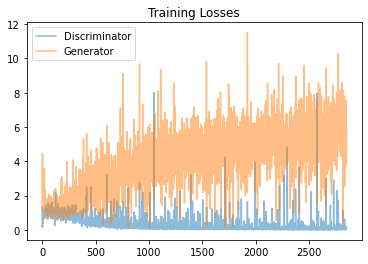

In [32]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [33]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [34]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

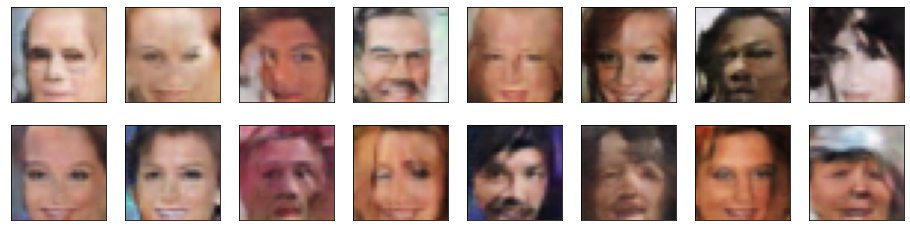

In [35]:
_ = view_samples(-1, samples)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.